In [1]:
# General
import sys; sys.path.append(2*'../')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tensordict.tensordict import TensorDict

# Kool et al. (2019)
# from problems.vrp.problem_vrp import CVRP
# from problems.vrp.state_cvrp import StateCVRP
# from nets.attention_model import AttentionModel, set_decode_type

# Ours
from rl4co.envs import CVRPEnv, TSPEnv
from rl4co.utils.ops import gather_by_index

/home/cbhua/miniconda3/envs/rl4co_new/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### ***Render for the TSP***

In [2]:
# Init environment
env = TSPEnv(num_loc=10)
td = env.reset(batch_size=[8])
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([8, 10]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([8]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        first_node: Tensor(shape=torch.Size([8]), device=cpu, dtype=torch.int64, is_shared=False),
        i: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        locs: Tensor(shape=torch.Size([8, 10, 2]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([8]),
    device=cpu,
    is_shared=False)


In [3]:
# Generate the action
actions = torch.tensor(range(env.num_loc)).unsqueeze(0).repeat(8, 1)
print(actions.size())

torch.Size([8, 10])


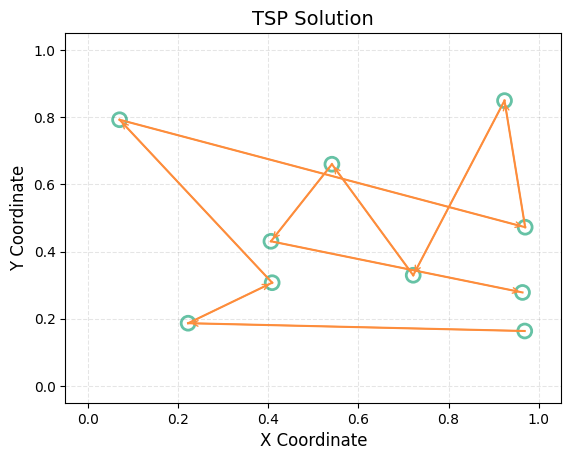

In [4]:
env.render(td, actions[0])

### ***Render for the CVRP***

In [7]:
# Init environment
env = CVRPEnv(num_loc=10)
td = env.reset(batch_size=[8])
print(td)

TensorDict(
    fields={
        action_mask: Tensor(shape=torch.Size([8, 11]), device=cpu, dtype=torch.bool, is_shared=False),
        current_node: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.int64, is_shared=False),
        demand: Tensor(shape=torch.Size([8, 10]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        locs: Tensor(shape=torch.Size([8, 11, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        used_capacity: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        vehicle_capacity: Tensor(shape=torch.Size([8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        visited: Tensor(shape=torch.Size([8, 1, 11]), device=cpu, dtype=torch.uint8, is_shared=False)},
    batch_size=torch.Size([8]),
    device=None,
    is_shared=False)


In [8]:
# Generate the action
actions = torch.tensor([0, 1, 2, 0, 3, 4, 0, 5, 6, 0, 7, 8, 0, 9, 10, 0])

11
10


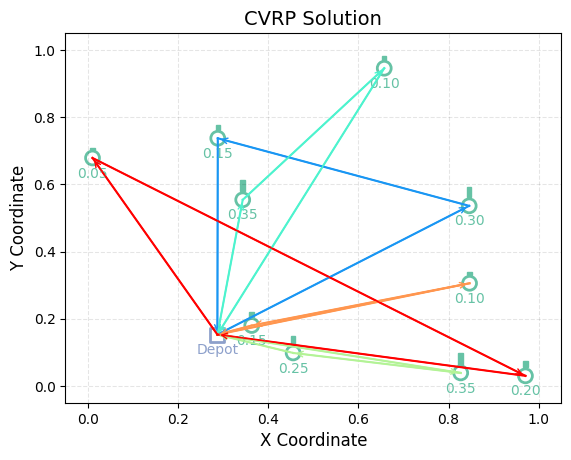

In [9]:
env.render(td, actions)

### ***Render for the CVRP (Dynamic)***

# Create variables
B = 16
N = 20

problem = CVRP()
dataset = problem.make_dataset(num_samples=B, size=N)

input_dict = {}

depots, locs, demands = [], [], []
for i in range(len(dataset)):
    ret = dataset[i]

    depots.append(ret['depot'])
    locs.append(ret['loc'])
    demands.append(ret['demand'])

input_dict['depot'] = torch.stack(depots, dim=0)
input_dict['loc'] = torch.stack(locs, dim=0)
input_dict['demand'] = torch.stack(demands, dim=0)

init_state = StateCVRP.initialize(input_dict)

am = AttentionModel(128, 128, problem)
set_decode_type(am, 'greedy')
cost, _, pi= am(input_dict, return_pi=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
d = next(iter(dataloader))
costs_kool = problem.get_costs(d, pi)[0]

# Kool
state_kool = StateCVRP.initialize(input_dict)

# Ours
cvrpenv = CVRPEnv(num_loc=N)
new_td = TensorDict(
    {
        "depot": input_dict['depot'],
        "locs": input_dict['loc'],
        "demand": input_dict['demand'] * 20,
        "capacity": torch.full((B,), 20),
    },
    batch_size=B,
)

td = cvrpenv.reset(new_td)

our_demands = []
kool_demands = []
our_mask = []
kool_mask = []
kool_used_capacity = []
our_dones = []

assert torch.allclose(td['demand'][...,1:], input_dict['demand']), "Demand should be the same"
assert torch.allclose(td['locs'][...,1:,:], input_dict['loc']), "Locs should be the same"
assert torch.allclose(td['depot'], input_dict['depot']), "Depot should be the same"

for p in pi.T:
    # Our step
    td.set("action", p)

    td = cvrpenv.step(td)["next"]

    our_demands.append(td['demand'].clone())
    our_mask.append(td['action_mask'].clone())
    our_dones.append(td['done'])

    # Kool step
    state_kool = state_kool.update(p)
    kool_demands.append(state_kool.demand)
    kool_mask.append(~state_kool.get_mask().squeeze(1)) # negation because of how the mask is defined
    kool_used_capacity.append(state_kool.used_capacity)

td_init = td

**Note**:
- `pi` [action_step, batch_size]

/tmp/ipykernel_1722175/1791622959.py:17: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  actions = pi[0].T


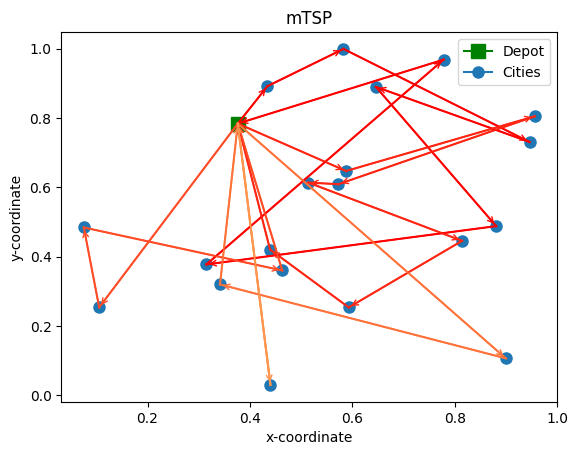

In [11]:
# Render function
def discrete_cmap(num, base_cmap="nipy_spectral"):
    """Create an N-bin discrete colormap from the specified input map"""
    base = colormaps[base_cmap]
    color_list = base(np.linspace(0, 1, num))
    cmap_name = base.name + str(num)
    return base.from_list(cmap_name, color_list, num)

td_init = td_init.detach().cpu()

# if batch_size greater than 0 , we need to select the first batch element
# first batch as example
if td.batch_size != torch.Size([]):
    td = td_init[0]

locs = td["locs"]

# get action list for batch 0
actions = pi[0].T 
num_agents = locs.size(-2)
cmap = discrete_cmap(num_agents, "rainbow")

fig, ax = plt.subplots()

# Add depot action = 0 to before first action and after last action
actions = torch.cat(
    [
        torch.zeros(1, dtype=torch.int64),
        actions,
        torch.zeros(1, dtype=torch.int64),
    ]
)

# Make list of colors from matplotlib
for i, loc in enumerate(locs):
    if i == 0:
        # depot
        marker = "s"
        color = "g"
        label = "Depot"
        markersize = 10
    else:
        # normal location
        marker = "o"
        color = "tab:blue"
        label = "Cities"
        markersize = 8
    if i > 1:
        label = ""

    ax.plot(
        loc[0],
        loc[1],
        color=color,
        marker=marker,
        markersize=markersize,
        label=label,
    )

# Plot the actions in order
agent_idx = 0
for i in range(len(actions)):
    if actions[i] == 0:
        agent_idx += 1
    color = cmap(num_agents - agent_idx)

    from_node = actions[i]
    to_node = (
        actions[i + 1] if i < len(actions) - 1 else actions[0]
    )  # last goes back to depot
    from_loc = td["locs"][from_node]
    to_loc = td["locs"][to_node]
    ax.plot([from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]], color=color)
    ax.annotate(
        "",
        xy=(to_loc[0], to_loc[1]),
        xytext=(from_loc[0], from_loc[1]),
        arrowprops=dict(arrowstyle="->", color=color),
        annotation_clip=False,
    )

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.set_title("CVRP")
ax.set_xlabel("x-coordinate")
ax.set_ylabel("y-coordinate")
plt.show()

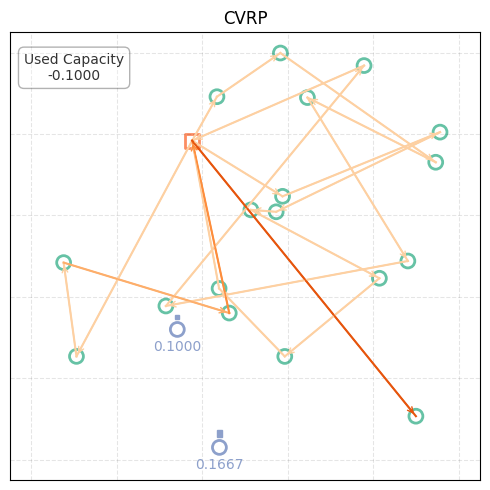

In [63]:
# SECTION: prepare data
from torch import fill

td_init = td_init.detach().cpu()

# take the first batch as the example
batch_idx = 0
step = 20 # action step
td = td_init[batch_idx]
locs = td["locs"]
num_node = locs.size(-2)
actions = pi[batch_idx].T 

# add depot at the beginning and end
actions = torch.cat([
    torch.zeros(1, dtype=torch.int64),
    actions,
    torch.zeros(1, dtype=torch.int64),
])

# SECTION: plot
fig, ax = plt.subplots(figsize=(5, 5))

# plot depot
ax.scatter(
    locs[0, 0], locs[0, 1], 
    edgecolors=cm.Set2(1),
    facecolors='none',
    s=100,
    linewidths=2,
    marker='s',
    alpha=1,
)

# plot visited nodes
visited_node = actions.clone()
visited_node[step+2:] = 0
visited_node = visited_node[torch.nonzero(visited_node)]
ax.scatter(
    locs[visited_node,0], locs[visited_node,1], 
    edgecolors=cm.Set2(0),
    facecolors='none',
    s=100,
    linewidths=2,
    marker='o',
    alpha=1,
)

# plot unvisited nodes
unvisited_node = actions.clone()
unvisited_node[:step+2] = 0
unvisited_node = unvisited_node[torch.nonzero(unvisited_node)]
ax.scatter(
    locs[unvisited_node,0], locs[unvisited_node,1], 
    edgecolors=cm.Set2(2),
    facecolors='none',
    s=100,
    linewidths=2,
    marker='o',
    alpha=1,
)

# plot unvisited demand bars
for node_idx in unvisited_node.squeeze():
    ax.add_patch(
        plt.Rectangle(
            (locs[node_idx,0]-0.005, locs[node_idx,1]+0.025), 
            0.01, 
            demands[batch_idx][node_idx]*0.1,
            edgecolor=cm.Set2(2),
            facecolor=cm.Set2(2),
            fill=True,
        )
    )

# text unvisited demand
for node_idx in unvisited_node.squeeze():
    ax.text(
        locs[node_idx,0], locs[node_idx,1]-0.025, 
        f'{demands[batch_idx][node_idx].item():.4f}',
        horizontalalignment='center',
        verticalalignment='top',
        fontsize=10,
        color=cm.Set2(2),
    )

# plot previsou actions
for action_idx in range(step-2):
    from_loc = locs[actions[action_idx]]
    to_loc = locs[actions[action_idx+1]]
    ax.plot(
        [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
        color=cm.tab20c(7),
    )
    ax.annotate(
        "", 
        xy=(to_loc[0], to_loc[1]),
        xytext=(from_loc[0], from_loc[1]),
        arrowprops=dict(arrowstyle="->", color=cm.tab20c(7)),
        annotation_clip=False,
    )

# plot recent actions
action_idx = step-2
from_loc = locs[actions[action_idx]]
to_loc = locs[actions[action_idx+1]]
ax.plot(
    [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
    color=cm.tab20c(6),
)
ax.annotate(
    "", 
    xy=(to_loc[0], to_loc[1]),
    xytext=(from_loc[0], from_loc[1]),
    arrowprops=dict(arrowstyle="->", color=cm.tab20c(6)),
    annotation_clip=False,
)

action_idx = step-1
from_loc = locs[actions[action_idx]]
to_loc = locs[actions[action_idx+1]]
ax.plot(
    [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
    color=cm.tab20c(5),
)
ax.annotate(
    "", 
    xy=(to_loc[0], to_loc[1]),
    xytext=(from_loc[0], from_loc[1]),
    arrowprops=dict(arrowstyle="->", color=cm.tab20c(5)),
    annotation_clip=False,
)

action_idx = step
from_loc = locs[actions[action_idx]]
to_loc = locs[actions[action_idx+1]]
ax.plot(
    [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
    color=cm.tab20c(4),
)
ax.annotate(
    "", 
    xy=(to_loc[0], to_loc[1]),
    xytext=(from_loc[0], from_loc[1]),
    arrowprops=dict(arrowstyle="->", color=cm.tab20c(4)),
    annotation_clip=False,
)
    
# plot used capacity text
ax.text(
    0.1, 1,
    f'Used Capacity\n{-demands[batch_idx][0].item():.4f}',
    horizontalalignment='center',
    verticalalignment='top',
    fontsize=10,
    color='black',
    alpha=0.8,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', alpha=0.3),
)

# setup
ax.set_title("CVRP")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(axis='both', color='black', ls='--', alpha=0.1)

plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.tight_layout()
plt.show()

In [113]:
from matplotlib import colormaps
def discrete_cmap(num, base_cmap="nipy_spectral"):
    """Create an N-bin discrete colormap from the specified input map"""
    base = colormaps[base_cmap]
    color_list = base(np.linspace(0, 1, num))
    cmap_name = base.name + str(num)
    return base.from_list(cmap_name, color_list, num)

out = discrete_cmap(6, "rainbow")

In [ ]:
# SECTION: prepare data
from torch import fill

td_init = td_init.detach().cpu()

# take the first batch as the example
batch_idx = 0
step = 0 # action step
td = td_init[batch_idx]
locs = td["locs"]
num_node = locs.size(-2)
actions = pi[batch_idx].T 

# add depot at the beginning and end
actions = torch.cat([
    torch.zeros(1, dtype=torch.int64),
    actions,
    torch.zeros(1, dtype=torch.int64),
])

for step in range(len(actions)-2):
    # SECTION: plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # plot depot
    ax.scatter(
        locs[0, 0], locs[0, 1], 
        edgecolors=cm.Set2(1),
        facecolors='none',
        s=100,
        linewidths=2,
        marker='s',
        alpha=1,
    )

    # plot visited nodes
    visited_node = actions.clone()
    visited_node[step+2:] = 0
    visited_node = visited_node[torch.nonzero(visited_node)]
    ax.scatter(
        locs[visited_node,0], locs[visited_node,1], 
        edgecolors=cm.Set2(0),
        facecolors='none',
        s=100,
        linewidths=2,
        marker='o',
        alpha=1,
    )

    # plot unvisited nodes
    unvisited_node = actions.clone()
    unvisited_node[:step+2] = 0
    unvisited_node = unvisited_node[torch.nonzero(unvisited_node)]
    ax.scatter(
        locs[unvisited_node,0], locs[unvisited_node,1], 
        edgecolors=cm.Set2(2),
        facecolors='none',
        s=100,
        linewidths=2,
        marker='o',
        alpha=1,
    )

    # plot unvisited demand bars
    for node_idx in unvisited_node.squeeze(dim=-1):
        ax.add_patch(
            plt.Rectangle(
                (locs[node_idx,0]-0.005, locs[node_idx,1]+0.025), 
                0.01, 
                demands[batch_idx][node_idx-1]*0.1,
                edgecolor=cm.Set2(2),
                facecolor=cm.Set2(2),
                fill=True,
            )
        )

    # text unvisited demand
    for node_idx in unvisited_node.squeeze(dim=-1):
        ax.text(
            locs[node_idx,0], locs[node_idx,1]-0.025, 
            f'{demands[batch_idx][node_idx-1].item():.4f}',
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=10,
            color=cm.Set2(2),
        )
    
    # plot previsou actions
    round_num = 0
    for action_idx in range(step-2):
        if actions[action_idx] == 0:
            round_num += 1
        color = out(round_num)

        from_loc = locs[actions[action_idx]]
        to_loc = locs[actions[action_idx+1]]
        ax.plot(
            [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
            color=color,
            alpha=0.5,
        )
        ax.annotate(
            "", 
            xy=(to_loc[0], to_loc[1]),
            xytext=(from_loc[0], from_loc[1]),
            arrowprops=dict(arrowstyle="->", color=color),
            annotation_clip=False,
            alpha=0.5,
        )

    # plot recent actions
    action_idx = max(step-2, 0)
    if actions[action_idx] == 0 and step-1 > 0:
        round_num += 1
    color = out(round_num)
    from_loc = locs[actions[action_idx]]
    to_loc = locs[actions[action_idx+1]]
    ax.plot(
        [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
        color=color,
        alpha=0.7
    )
    ax.annotate(
        "", 
        xy=(to_loc[0], to_loc[1]),
        xytext=(from_loc[0], from_loc[1]),
        arrowprops=dict(arrowstyle="->", color=color),
        annotation_clip=False,
        alpha=0.7,
    )

    action_idx = max(step-1, 0)
    if actions[action_idx] == 0 and step > 0:
        round_num += 1
    color = out(round_num)
    from_loc = locs[actions[action_idx]]
    to_loc = locs[actions[action_idx+1]]
    ax.plot(
        [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
        color=color,
        alpha=0.8
    )
    ax.annotate(
        "", 
        xy=(to_loc[0], to_loc[1]),
        xytext=(from_loc[0], from_loc[1]),
        arrowprops=dict(arrowstyle="->", color=color),
        annotation_clip=False,
        alpha=0.8
    )

    action_idx = step
    if actions[action_idx] == 0:
        round_num += 1
    color = out(round_num)
    from_loc = locs[actions[action_idx]]
    to_loc = locs[actions[action_idx+1]]
    ax.plot(
        [from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]],
        color=color,
    )
    ax.annotate(
        "", 
        xy=(to_loc[0], to_loc[1]),
        xytext=(from_loc[0], from_loc[1]),
        arrowprops=dict(arrowstyle="->", color=color),
        annotation_clip=False,
    )
        
    # plot used capacity text
    # ax.text(
    #     0.1, 1,
    #     f'Used Capacity\n{demands[batch_idx][0].item():.4f}',
    #     horizontalalignment='center',
    #     verticalalignment='top',
    #     fontsize=10,
    #     color='black',
    #     alpha=0.8,
    #     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.4', alpha=0.3),
    # )

    # setup
    ax.set_title("CVRP")
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(axis='both', color='black', ls='--', alpha=0.1)

    plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'images/our/{step}.png')

In [115]:
import imageio

frames = []
for t in range(len(actions)-2):
    frames.append(imageio.v2.imread(f'images/our/{t}.png'))

imageio.mimsave(
    'images/our.gif',
    frames,
    duration=500
)